*coding: utf-8*

# Pipeline de Modelagem Preditiva Refatorado com Otimização e Análise de Overfitting

Este notebook implementa um fluxo de trabalho de machine learning completo e robusto
para prever parâmetros fisiológicos durante o exercício. Ele segue as melhores
práticas da ciência de dados, incluindo:

1.  **Análise Exploratória de Dados (EDA)**: Focada em multicollinearidade.
2.  **Pré-processamento com Pipeline**: Para garantir a consistência e evitar vazamento de dados.
3.  **Otimização de Hiperparâmetros**: Usando `GridSearchCV` para encontrar a melhor configuração para cada modelo.
4.  **Validação Cruzada Robusta**: Usando `GroupKFold` dentro do GridSearchCV para respeitar a estrutura de dados.
5.  **Diagnóstico de Overfitting**: Comparando as métricas de performance nos dados de treino e teste.
6.  **Interpretabilidade do Modelo**: Utilizando SHAP para entender as predições do melhor modelo otimizado.

**Autor**: Letícia Gontijo
**Data**: 2024-08

In [9]:
# =============================================================================
# 1. SETUP E IMPORTAÇÃO DAS BIBLIOTECAS
# =============================================================================
# Bibliotecas padrão para manipulação de dados e visualização
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Componentes do Scikit-learn para modelagem e otimização
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Import do XGBoost. Pode ser necessário instalar: pip install xgboost
import xgboost as xgb

# Biblioteca para interpretabilidade do modelo
import shap

# Configurações de visualização para melhor aparência dos gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [17]:
# =============================================================================
# 2. CARREGAMENTO E PRÉ-PROCESSAMENTO (MODIFICADO)
# =============================================================================
print("--- 2. Carregando o Novo Banco de Dados Organizado ---")

# --- MODIFICAÇÃO CHAVE ---
# Carregamos o novo ficheiro CSV, que já está limpo e organizado.
try:
    df_exercicio = pd.read_csv('/home/leticia/Documentos/tcore/data/dados-organizados-1-1km.csv')
    print("Novo dataset 'dados-organizados-1-1km.csv' carregado com sucesso.")
    print(f"Formato do dataset: {df_exercicio.shape}")
except FileNotFoundError:
    print("ERRO: O ficheiro 'dados-organizados-1-1km.csv' não foi encontrado.")
    df_exercicio = pd.DataFrame() # Cria um DataFrame vazio para evitar erros

if not df_exercicio.empty:
    # --- MODIFICAÇÃO CHAVE ---
    # A lógica complexa para criar 'trial_id' foi REMOVIDA,
    # pois o novo ficheiro já contém esta coluna de forma correta.
    
    # Apenas removemos a variável 'pacing' por ser redundante com 'velocidade'.
    if 'pacing' in df_exercicio.columns:
        df_exercicio = df_exercicio.drop(columns=['pacing'])
        print("Variável 'pacing' removida por redundância com 'velocidade'.")
    
    print(f"Número de ensaios/sujeitos únicos no dataset: {df_exercicio['trial_id'].nunique()}")


--- 2. Carregando o Novo Banco de Dados Organizado ---
Novo dataset 'dados-organizados-1-1km.csv' carregado com sucesso.
Formato do dataset: (750, 18)
Variável 'pacing' removida por redundância com 'velocidade'.
Número de ensaios/sujeitos únicos no dataset: 75



--- 3. Análise de Multicollinearidade ---


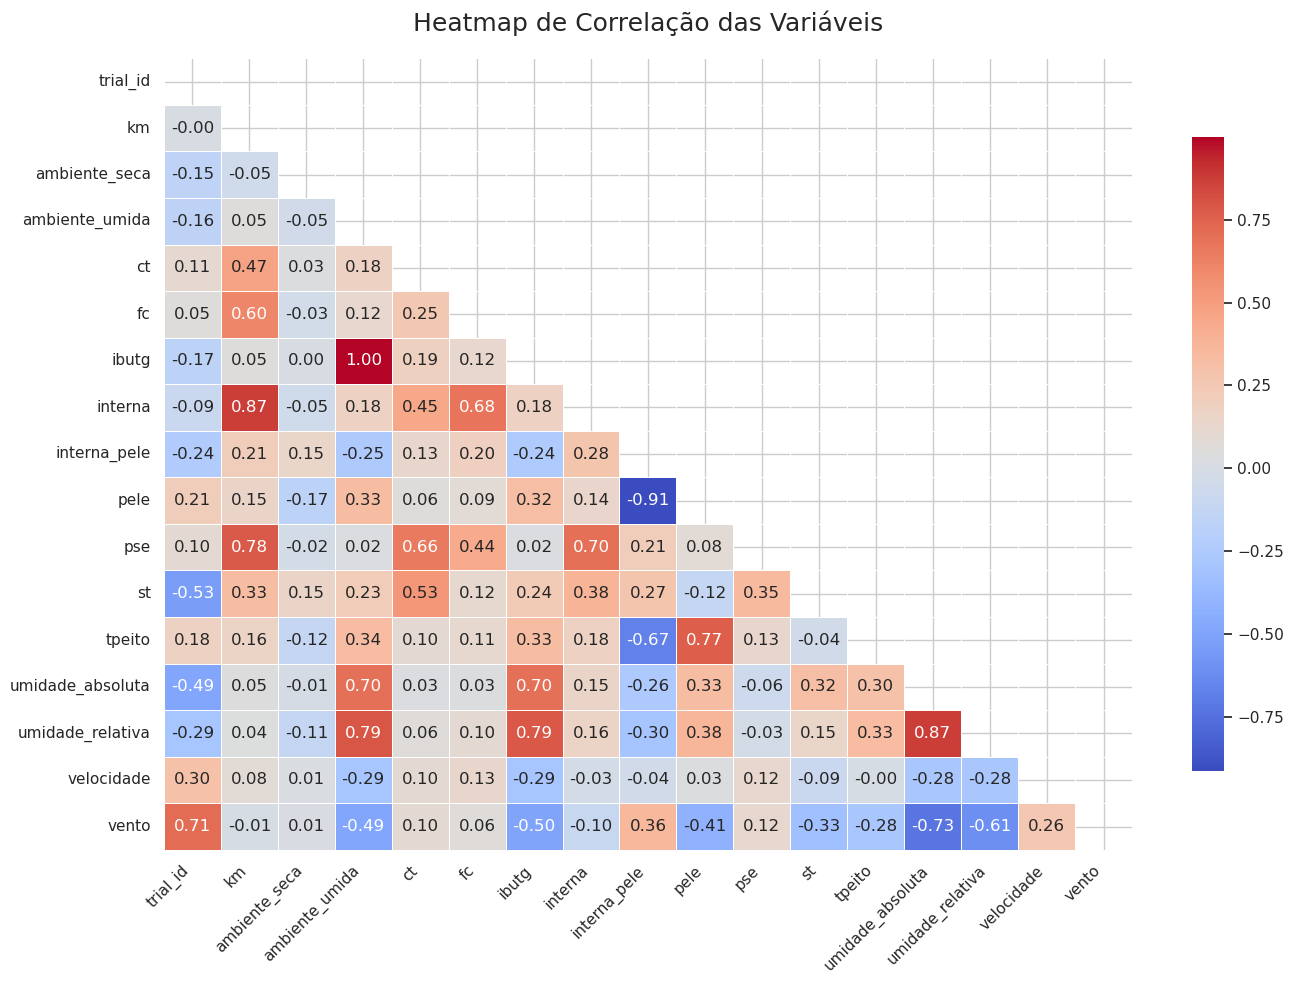

In [18]:
# =============================================================================
# 3. ANÁLISE EXPLORATÓRIA: MULTICOLLINEARIDADE
# =============================================================================
if not df_exercicio.empty:
    print("\n--- 3. Análise de Multicollinearidade ---")
    
    numeric_cols = df_exercicio.select_dtypes(include=np.number)
    corr_matrix = numeric_cols.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('Heatmap de Correlação das Variáveis', fontsize=18, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

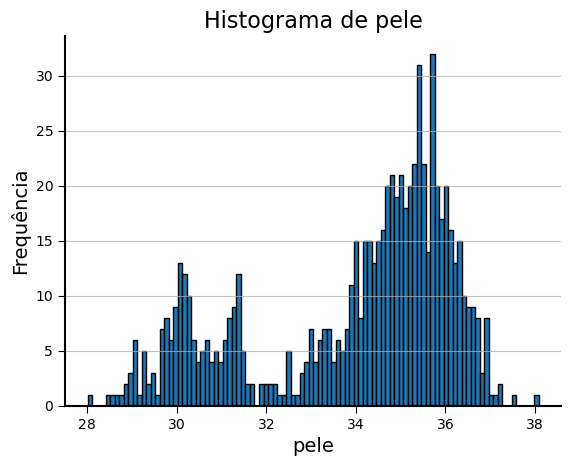

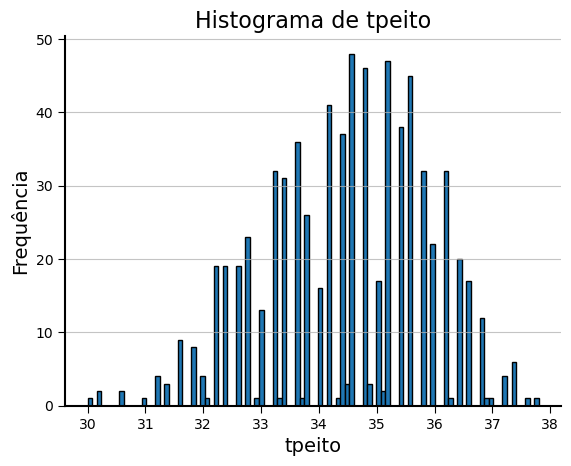

In [55]:
for col in df_exercicio:
    if col == 'tpeito' or col == 'pele':
        plt.hist(df_exercicio[col], bins=100, edgecolor='black')
        plt.title(f'Histograma de {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequência', fontsize=14)
        plt.grid(axis='y', alpha=0.75)
        plt.show()

In [ ]:
# =============================================================================
# 4. CONFIGURAÇÃO DOS EXPERIMENTOS E OTIMIZAÇÃO
# =============================================================================
if not df_exercicio.empty:
    print("\n--- 4. Configurando os Experimentos e Grades de Hiperparâmetros ---")

    TARGET = 'interna'

    FEATURE_SETS = {
        #'all_features': [col for col in df_exercicio.columns if col not in [TARGET, 'trial_id']],
        'simple': ['km', 'ibutg', 'pele', 'fc'],
        'simple_com_velocidade': ['km', 'ibutg', 'pele', 'fc', 'velocidade'],
        'ambiental_completo': ['km', 'ibutg', 'umidade_absoluta', 'umidade_relativa',
                               'ambiente_seca', 'ambiente_umida', 'pele', 'fc']
    }

    # Definir os modelos base
    MODELS = {
        'Lasso': Lasso(random_state=42, max_iter=20000),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    }

    # Definir as grades de hiperparâmetros para o GridSearchCV
    # Nota: Os nomes dos parâmetros devem ser prefixados com 'model__' por causa do Pipeline.
PARAM_GRIDS = {

    'Lasso': {
        'model__alpha': np.linspace(0.005, 0.05, 20)
    },
    
    'DecisionTree': {
        'model__max_depth': [10, 15, 20], 
        'model__min_samples_split': [5, 10], 
        'model__min_samples_leaf': [15, 20, 25] 
    },
    
    
    'RandomForest': {
        'model__n_estimators': [200, 300, 400],
        'model__max_features': [0.7, 0.8, 1.0],
        'model__min_samples_split': [30, 40],
        'model__min_samples_leaf': [10, 20],  
        'model__max_samples': [0.8, None] 
    },
    
    'XGBoost': {
        'model__learning_rate': [0.02, 0.05, 0.1], 
        'model__n_estimators': [350, 500, 700],
        'model__max_depth': [3, 4], 
        'model__gamma': [1.0, 1.5], 
        'model__subsample': [0.5, 0.8],
        'model__colsample_bytree': [0.5, 0.7],
        'model__reg_alpha': [0.1, 0.5],
        'model__reg_lambda': [4, 6, 8] 
    }
}
print("Modelos e grades de hiperparâmetros definidos.")


--- 4. Configurando os Experimentos e Grades de Hiperparâmetros ---
Modelos e grades de hiperparâmetros definidos.


In [120]:
# =============================================================================
# 5. EXECUÇÃO DA OTIMIZAÇÃO E AVALIAÇÃO
# =============================================================================
if not df_exercicio.empty:
    print("\n--- 5. Executando a Otimização de Hiperparâmetros com GridSearchCV ---")
    
    X = df_exercicio.drop(columns=[TARGET, 'trial_id'])
    y = df_exercicio[TARGET]
    groups = df_exercicio['trial_id']
    
    results = []
    
    cv_strategy = GroupKFold(n_splits=5)

    # Definir os scorers para o GridSearchCV
    scoring = {
        'r2': 'r2',
        'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
    }

    for model_name, model_instance in MODELS.items():
        for feature_set_name, feature_list in FEATURE_SETS.items():
            print(f"  Otimizando: Modelo='{model_name}', Features='{feature_set_name}'...")
            
            X_subset = X[feature_list]
            pipeline = Pipeline([('scaler', StandardScaler()), ('model', model_instance)])
            param_grid = PARAM_GRIDS[model_name]
            
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=cv_strategy,
                scoring=scoring,
                refit='r2', # Otimizar com base no R², mas reportar ambos
                n_jobs=-1,
                return_train_score=True, # Essencial para análise de overfitting
                verbose=0
            )
            
            grid_search.fit(X_subset, y, groups=groups)
            
            # Encontrar o índice do melhor resultado
            best_index = grid_search.best_index_
            
            # Extrair as métricas de treino e teste para o melhor modelo
            r2_teste = grid_search.cv_results_['mean_test_r2'][best_index]
            rmse_teste = -grid_search.cv_results_['mean_test_rmse'][best_index]
            r2_treino = grid_search.cv_results_['mean_train_r2'][best_index]
            rmse_treino = -grid_search.cv_results_['mean_train_rmse'][best_index]
            
            results.append({
                'model': model_name,
                'feature_set': feature_set_name,
                'R2_treino': r2_treino,
                'R2_teste': r2_teste,
                'RMSE_treino': rmse_treino,
                'RMSE_teste': rmse_teste,
                'best_params': grid_search.best_params_
            })

    results_df = pd.DataFrame(results)
    print("\nOtimização e avaliação concluídas.")


--- 5. Executando a Otimização de Hiperparâmetros com GridSearchCV ---
  Otimizando: Modelo='Lasso', Features='simple'...
  Otimizando: Modelo='Lasso', Features='simple_com_velocidade'...
  Otimizando: Modelo='Lasso', Features='ambiental_completo'...
  Otimizando: Modelo='DecisionTree', Features='simple'...
  Otimizando: Modelo='DecisionTree', Features='simple_com_velocidade'...
  Otimizando: Modelo='DecisionTree', Features='ambiental_completo'...
  Otimizando: Modelo='RandomForest', Features='simple'...
  Otimizando: Modelo='RandomForest', Features='simple_com_velocidade'...
  Otimizando: Modelo='RandomForest', Features='ambiental_completo'...
  Otimizando: Modelo='XGBoost', Features='simple'...
  Otimizando: Modelo='XGBoost', Features='simple_com_velocidade'...
  Otimizando: Modelo='XGBoost', Features='ambiental_completo'...

Otimização e avaliação concluídas.



--- 6. Análise Comparativa dos Resultados Otimizados ---
Tabela de Resultados (ordenado pelo menor RMSE de Teste):


,model,feature_set,R2_treino,R2_teste,RMSE_treino,RMSE_teste,best_params
11,XGBoost,ambiental_completo,0.855970,0.800305,0.362494,0.424297,"{'model__colsample_bytree': 0.5, 'model__gamma': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__reg_alpha': 0.5, 'model__reg_lambda': 8, 'model__subsample': 0.5}"
9,XGBoost,simple,0.858987,0.796364,0.358676,0.428335,"{'model__colsample_bytree': 0.5, 'model__gamma': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 700, 'model__reg_alpha': 0.1, 'model__reg_lambda': 6, 'model__subsample': 0.5}"
0,Lasso,simple,0.812805,0.794522,0.413240,0.430285,{'model__alpha': 0.00736842105263158}
10,XGBoost,simple_com_velocidade,0.858006,0.793386,0.359905,0.431236,"{'model__colsample_bytree': 0.5, 'model__gamma': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__reg_alpha': 0.5, 'model__reg_lambda': 8, 'model__subsample': 0.5}"
2,Lasso,ambiental_completo,0.814748,0.792556,0.411105,0.432467,{'model__alpha': 0.016842105263157894}
7,RandomForest,simple_com_velocidade,0.854030,0.791194,0.364935,0.433462,"{'model__max_features': 0.7, 'model__max_samples': 0.8, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__n_estimators': 300}"
1,Lasso,simple_com_velocidade,0.821423,0.790375,0.403597,0.433771,{'model__alpha': 0.019210526315789477}
8,RandomForest,ambiental_completo,0.851993,0.790002,0.367450,0.434681,"{'model__max_features': 0.7, 'model__max_samples': 0.8, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__n_estimators': 300}"
6,RandomForest,simple,0.846174,0.789695,0.374604,0.435068,"{'model__max_features': 0.7, 'model__max_samples': 0.8, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__n_estimators': 400}"
5,DecisionTree,ambiental_completo,0.822711,0.754961,0.402069,0.469161,"{'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 5}"


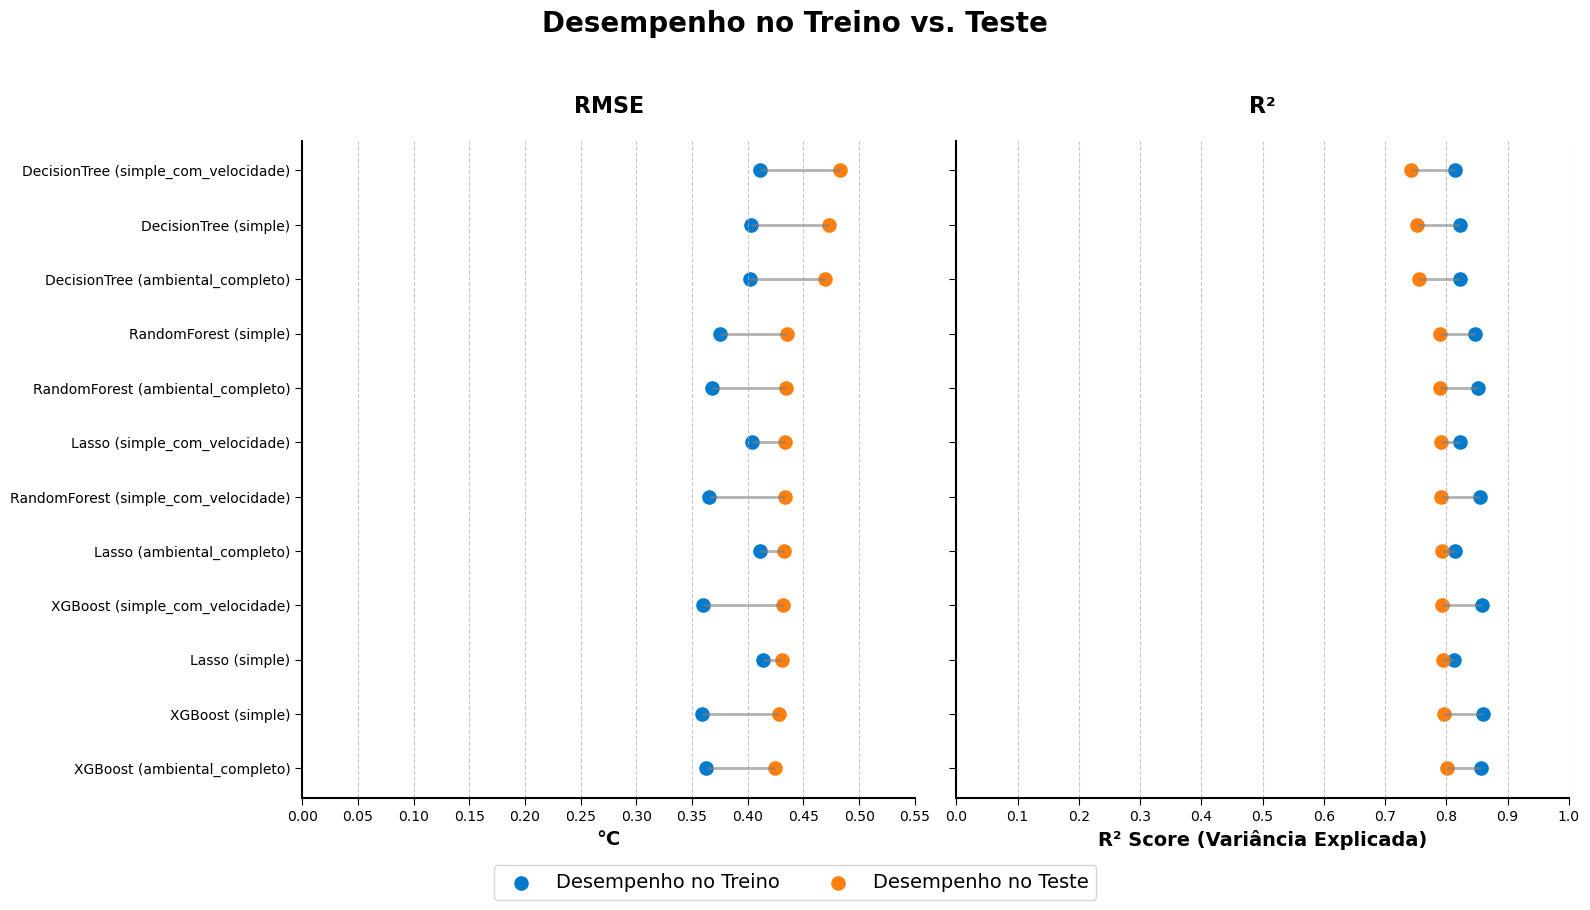

In [136]:
# =============================================================================
# 6. ANÁLISE E VISUALIZAÇÃO DOS RESULTADOS (ESTILO INTUITIVO)
# =============================================================================
if not df_exercicio.empty:
    print("\n--- 6. Análise Comparativa dos Resultados Otimizados ---")
    
    # Criar uma coluna de identificação única para cada experimento
    results_df['experimento'] = results_df['model'] + ' (' + results_df['feature_set'] + ')'
    
    # Ordenar os resultados pelo erro no teste (melhor para pior)
    results_df_sorted = results_df.sort_values('RMSE_teste', ascending=False).reset_index(drop=True)
    
    print("Tabela de Resultados (ordenado pelo menor RMSE de Teste):")
    pd.set_option('display.max_colwidth', None)
    display_cols = ['model', 'feature_set', 'R2_treino', 'R2_teste', 'RMSE_treino', 'RMSE_teste', 'best_params']
    display(results_df.sort_values('RMSE_teste', ascending=True)[display_cols])
    
    # --- Configuração do Estilo do Gráfico ---
    plt.style.use('default')
    plt.rcParams.update({
        'axes.facecolor': 'white', 'axes.edgecolor': 'black',
        'axes.linewidth': 1.5, 'xtick.color': 'black', 'ytick.color': 'black',
        'axes.labelcolor': 'black', 'figure.facecolor': 'white',
        'axes.spines.top': False, 'axes.spines.right': False,
        'xtick.major.size': 5, 'ytick.major.size': 5,
    })

    # --- Criação do Gráfico de Halteres (Dumbbell Plot) para RMSE e R² ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharey=True)

    # --- Gráfico de RMSE (Esquerda) ---
    ax1 = axes[0]
    ax1.hlines(y=results_df_sorted.index, 
               xmin=results_df_sorted['RMSE_treino'], 
               xmax=results_df_sorted['RMSE_teste'], 
               color='grey', alpha=0.6, linewidth=2)
    ax1.scatter(results_df_sorted['RMSE_treino'], results_df_sorted.index, 
                color='#007acc', alpha=1, s=90, label='Desempenho no Treino')
    ax1.scatter(results_df_sorted['RMSE_teste'], results_df_sorted.index, 
                color='#ff7f0e', alpha=1, s=90, label='Desempenho no Teste')
    ax1.set_xlabel('°C', fontsize=14, weight='bold')
    ax1.set_title('RMSE', fontsize=16, weight='bold', pad=20)
    ax1.grid(axis='x', linestyle='--', alpha=0.7)
    ax1.set_xticks(np.arange(0.0, 0.57, 0.05))

    # --- Gráfico de R² (Direita) ---
    ax2 = axes[1]
    ax2.hlines(y=results_df_sorted.index, 
               xmin=results_df_sorted['R2_treino'], 
               xmax=results_df_sorted['R2_teste'], 
               color='grey', alpha=0.6, linewidth=2)
    ax2.scatter(results_df_sorted['R2_treino'], results_df_sorted.index, 
                color='#007acc', alpha=1, s=90)
    ax2.scatter(results_df_sorted['R2_teste'], results_df_sorted.index, 
                color='#ff7f0e', alpha=1, s=90)
    ax2.set_xlabel('R² Score (Variância Explicada)', fontsize=14, weight='bold')
    ax2.set_title('R²', fontsize=16, weight='bold', pad=20)
    ax2.grid(axis='x', linestyle='--', alpha=0.7)
    # Definir limites para o eixo x do R² para melhor visualização
    ax2.set_xticks(np.arange(0.0, 1.05, 0.1))


    # --- Configurações Comuns ---
    # Adicionar os nomes dos experimentos no eixo Y (apenas no primeiro gráfico)
    plt.yticks(results_df_sorted.index, results_df_sorted['experimento'], fontsize=12)
    
    # Inverter o eixo Y para colocar o melhor resultado (menor RMSE) no topo
    ax1.invert_yaxis()
    
    # Adicionar uma única legenda para a figura inteira
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=14, frameon=True)
    
    # Título geral
    fig.suptitle('Desempenho no Treino vs. Teste', fontsize=20, weight='bold', y=0.98)
    
    plt.tight_layout(rect=[0.0, 0.03, 1, 0.95]) # Ajustar layout para o título e legenda
    plt.show()

In [132]:
results_df

,model,feature_set,R2_treino,R2_teste,RMSE_treino,RMSE_teste,best_params,experimento
0,Lasso,simple,0.812805,0.794522,0.413240,0.430285,{'model__alpha': 0.00736842105263158},Lasso (simple)
1,Lasso,simple_com_velocidade,0.821423,0.790375,0.403597,0.433771,{'model__alpha': 0.019210526315789477},Lasso (simple_com_velocidade)
2,Lasso,ambiental_completo,0.814748,0.792556,0.411105,0.432467,{'model__alpha': 0.016842105263157894},Lasso (ambiental_completo)
3,DecisionTree,simple,0.821713,0.751463,0.403181,0.472869,"{'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 5}",DecisionTree (simple)
4,DecisionTree,simple_com_velocidade,0.814666,0.741715,0.411155,0.482418,"{'model__max_depth': 10, 'model__min_samples_leaf': 25, 'model__min_samples_split': 5}",DecisionTree (simple_com_velocidade)
5,DecisionTree,ambiental_completo,0.822711,0.754961,0.402069,0.469161,"{'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 5}",DecisionTree (ambiental_completo)
6,RandomForest,simple,0.846174,0.789695,0.374604,0.435068,"{'model__max_features': 0.7, 'model__max_samples': 0.8, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__n_estimators': 400}",RandomForest (simple)
7,RandomForest,simple_com_velocidade,0.854030,0.791194,0.364935,0.433462,"{'model__max_features': 0.7, 'model__max_samples': 0.8, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__n_estimators': 300}",RandomForest (simple_com_velocidade)
8,RandomForest,ambiental_completo,0.851993,0.790002,0.367450,0.434681,"{'model__max_features': 0.7, 'model__max_samples': 0.8, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__n_estimators': 300}",RandomForest (ambiental_completo)
9,XGBoost,simple,0.858987,0.796364,0.358676,0.428335,"{'model__colsample_bytree': 0.5, 'model__gamma': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 700, 'model__reg_alpha': 0.1, 'model__reg_lambda': 6, 'model__subsample': 0.5}",XGBoost (simple)



--- 7. Análise de Interpretabilidade com SHAP ---
Melhor combinação global encontrada:
  - Modelo: 'XGBoost', Features: 'ambiental_completo'
  - R² Teste: 0.8003
  - RMSE Teste: 0.4243

Melhor modelo otimizado treinado com todos os dados.
Calculando os valores SHAP...
Gerando gráficos SHAP...


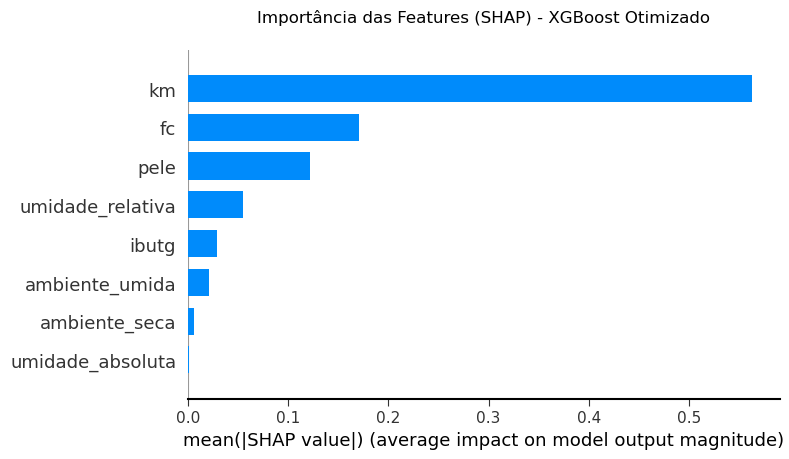

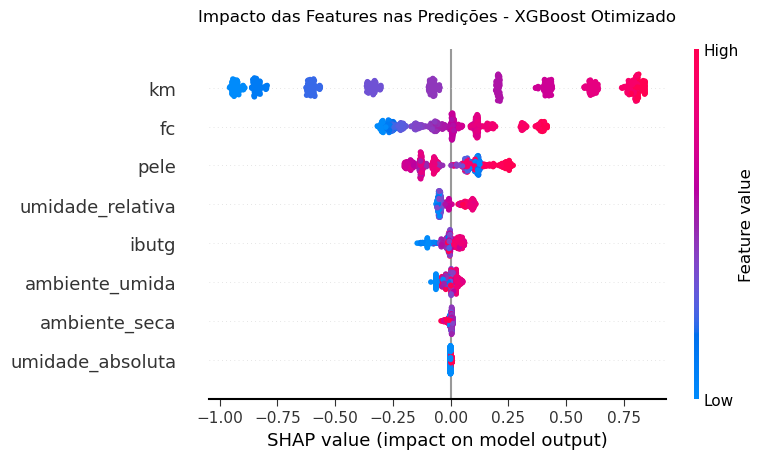

In [133]:
# =============================================================================
# 7. ANÁLISE DE INTERPRETABILIDADE (SHAP) COM O MELHOR MODELO OTIMIZADO
# =============================================================================
if not df_exercicio.empty and not results_df.empty:
    print("\n--- 7. Análise de Interpretabilidade com SHAP ---")
    
    best_experiment = results_df.sort_values('RMSE_teste').iloc[0]
    best_model_name = best_experiment['model']
    best_feature_set_name = best_experiment['feature_set']
    best_params = best_experiment['best_params']
    
    print(f"Melhor combinação global encontrada:")
    print(f"  - Modelo: '{best_model_name}', Features: '{best_feature_set_name}'")
    print(f"  - R² Teste: {best_experiment['R2_teste']:.4f}")
    print(f"  - RMSE Teste: {best_experiment['RMSE_teste']:.4f}")

    final_model_instance = MODELS[best_model_name]
    final_model_params = {key.replace('model__', ''): value for key, value in dict(best_params).items()}
    final_model_instance.set_params(**final_model_params)

    best_features = FEATURE_SETS[best_feature_set_name]
    X_best = X[best_features]

    final_pipeline = Pipeline([('scaler', StandardScaler()), ('model', final_model_instance)])
    final_pipeline.fit(X_best, y)
    print("\nMelhor modelo otimizado treinado com todos os dados.")

    scaler_fitted = final_pipeline.named_steps['scaler']
    X_best_scaled = scaler_fitted.transform(X_best)
    X_best_scaled_df = pd.DataFrame(X_best_scaled, columns=best_features)
    model_fitted = final_pipeline.named_steps['model']

    print("Calculando os valores SHAP...")
    
    # --- MODIFICAÇÃO: Lógica para selecionar o explainer correto ---
    if any(model_name in best_model_name for model_name in ['DecisionTree', 'RandomForest', 'XGBoost']):
        explainer = shap.TreeExplainer(model_fitted)
        shap_values = explainer.shap_values(X_best_scaled_df)
    elif 'Lasso' in best_model_name:
        # Para modelos lineares, shap.LinearExplainer é o mais eficiente.
        explainer = shap.LinearExplainer(model_fitted, X_best_scaled_df)
        shap_values = explainer.shap_values(X_best_scaled_df)
    else:
        # Um fallback para outros modelos, embora seja mais lento.
        print(f"Aviso: Usando KernelExplainer para o modelo '{best_model_name}'. Isso pode ser lento.")
        explainer = shap.KernelExplainer(model_fitted.predict, X_best_scaled_df)
        shap_values = explainer.shap_values(X_best_scaled_df)

    print("Gerando gráficos SHAP...")
    
    # O código de plotagem agora funciona para qualquer tipo de explainer
    plt.figure()
    shap.summary_plot(shap_values, X_best_scaled_df, plot_type="bar", show=False)
    plt.title(f'Importância das Features (SHAP) - {best_model_name} Otimizado', pad=20)
    plt.tight_layout()
    plt.show()

    plt.figure()
    shap.summary_plot(shap_values, X_best_scaled_df, show=False)
    plt.title(f'Impacto das Features nas Predições - {best_model_name} Otimizado', pad=20)
    plt.tight_layout()
    plt.show()

In [26]:
# =============================================================================
# 8. CONCLUSÕES
# =============================================================================
if not df_exercicio.empty:
    print("\n--- 8. Conclusões Finais ---")
    print("O pipeline refatorado permitiu uma avaliação sistemática, otimização e robusta dos modelos.")
    print(f"Após a otimização com GridSearchCV, o modelo '{best_model_name}' com o conjunto de features '{best_feature_set_name}' demonstrou ser o mais performático.")
    print("A análise SHAP no modelo otimizado revelou as contribuições de cada variável, oferecendo insights valiosos sobre os fatores que mais influenciam a temperatura interna.")
    print("Este fluxo de trabalho agora serve como uma base sólida para futuras investigações e para a publicação dos resultados, demonstrando uma metodologia de modelagem rigorosa.")



--- 8. Conclusões Finais ---
O pipeline refatorado permitiu uma avaliação sistemática, otimização e robusta dos modelos.
Após a otimização com GridSearchCV, o modelo 'XGBoost' com o conjunto de features 'ambiental_completo' demonstrou ser o mais performático.
A análise SHAP no modelo otimizado revelou as contribuições de cada variável, oferecendo insights valiosos sobre os fatores que mais influenciam a temperatura interna.
Este fluxo de trabalho agora serve como uma base sólida para futuras investigações e para a publicação dos resultados, demonstrando uma metodologia de modelagem rigorosa.
